# Separating Capacity and Utility 

## Overview 

The capacity and utility features are highly correlated (see below). This can affect overall model performance and feature importances.

To understand the extent of this effect we fit separate models to capacity and utility features, and compare performance.


- Capacity features: 111 calls offered, Ambulance answered, GP appointments available
- Utility features: 111 calls answered, Ambulance made

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(74,)

## Feature correlations 

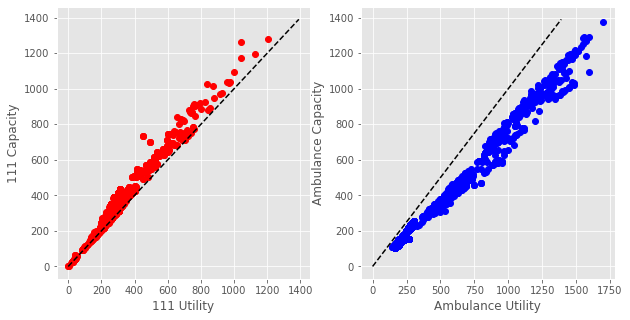

In [6]:
fig,ax_list = plt.subplots(1,2, figsize = (10,5))

xx = np.arange(0,140)*10

ax = ax_list[0]

ax.plot(dta['111_111_answered'].values, dta['111_111_offered'].values, 'ro')
ax.set_xlabel('111 Utility')
ax.set_ylabel('111 Capacity')
ax.plot(xx,xx, 'k--')

ax = ax_list[1]

ax.plot(dta['amb_sys_made'].values, dta['amb_sys_answered'].values, 'bo')
ax.set_xlabel('Ambulance Utility')
ax.set_ylabel('Ambulance Capacity')
ax.plot(xx,xx,'k--')

plt.show()

## Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1618, 14)

## Fitting function 

In [9]:
def fit_model(dta, model, features):
    
    
    y = dta['ae_attendances_attendances']
    X = dta[features]
    
    #cross validate to get errors on performance and coefficients
    cv_model = cross_validate(model, X,y, 
                            cv=RepeatedKFold(n_splits=5, n_repeats=5,
                                             random_state=0),
                            return_estimator=True, 
                              return_train_score=True, n_jobs=2)
    
    clf = model.fit(X, y)

    
    return cv_model

## Utility Model 

In [10]:
features = ['111_111_answered', 'amb_sys_made', 'rand1']

### Linear Regression 

In [11]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [12]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.083855,0.089997
std,0.023747,0.004965
min,0.046392,0.074933
25%,0.072955,0.087500
50%,0.084371,0.089937
75%,0.096630,0.093126
max,0.161442,0.100655


#### Coefficients 

In [13]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.388187,-0.136642,-3.708228
std,0.016808,0.007403,12.305010
min,0.339519,-0.149784,-25.111645
25%,0.380248,-0.142231,-9.562033
50%,0.388083,-0.135624,-4.667144
75%,0.395557,-0.132207,4.321049
max,0.427379,-0.121675,19.347927


### Random Forest 

In [14]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [15]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.236590,0.894535
std,0.066466,0.003297
min,0.112391,0.888562
25%,0.197762,0.892035
50%,0.243202,0.894518
75%,0.279811,0.897373
max,0.331515,0.901216


#### Coefficients 

In [16]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.207987,0.440134,0.351879
std,0.005848,0.009332,0.009254
min,0.195764,0.424368,0.326420
25%,0.205005,0.433463,0.347748
50%,0.207886,0.440542,0.351117
75%,0.211373,0.444091,0.357582
max,0.221227,0.465251,0.368511


### Gradient Boosted Trees 

In [17]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [18]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.337244,0.493172
std,0.038370,0.009531
min,0.246938,0.475122
25%,0.305860,0.488163
50%,0.347487,0.493584
75%,0.369488,0.497437
max,0.387623,0.512314


#### Coefficients 

In [19]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.196963,0.671507,0.131530
std,0.009310,0.014289,0.010002
min,0.180775,0.638809,0.114408
25%,0.190780,0.660383,0.124134
50%,0.197679,0.673083,0.130621
75%,0.204245,0.681347,0.137798
max,0.211885,0.697861,0.149508


### Summary 

Linear regression performs poorly, with an $R^2$ < 0.1

Random Forest overfits to the training data, and the random variable is comparatively important

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.

## Capacity Model 

In [20]:
features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

### Linear Regression 

In [21]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [22]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.102073,0.108765
std,0.026177,0.005678
min,0.052969,0.092187
25%,0.088854,0.105822
50%,0.104882,0.108816
75%,0.113505,0.112577
max,0.188438,0.122830


#### Coefficients 

In [23]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.009613,0.481967,-0.108094,-1.058362
std,0.003273,0.012217,0.009119,12.414753
min,0.002709,0.451203,-0.125017,-21.694177
25%,0.007641,0.478179,-0.115796,-7.409371
50%,0.010039,0.481001,-0.107188,-2.177476
75%,0.011166,0.487988,-0.101752,8.037063
max,0.016756,0.509044,-0.089849,21.684858


### Random Forest 

In [24]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [25]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.380144,0.914196
std,0.064979,0.003352
min,0.232751,0.908657
25%,0.335715,0.912098
50%,0.389321,0.913890
75%,0.425642,0.916405
max,0.510369,0.921425


#### Coefficients 

In [26]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.239598,0.189017,0.401606,0.169778
std,0.005962,0.011403,0.013790,0.007099
min,0.229238,0.167500,0.378487,0.150998
25%,0.234416,0.181186,0.392606,0.164699
50%,0.239503,0.187306,0.400261,0.170325
75%,0.243710,0.197662,0.410551,0.173957
max,0.251220,0.216889,0.437289,0.183189


### Gradient Boosted Trees 

In [27]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [28]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.401899,0.565627
std,0.050106,0.009447
min,0.310316,0.549283
25%,0.369650,0.556523
50%,0.405141,0.567855
75%,0.437094,0.573057
max,0.491685,0.584443


#### Coefficients 

In [29]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.161047,0.182368,0.598112,0.058473
std,0.011149,0.014722,0.016180,0.007970
min,0.136198,0.153994,0.561232,0.043424
25%,0.156540,0.175966,0.589252,0.053474
50%,0.161440,0.180021,0.599186,0.057511
75%,0.168531,0.189533,0.608987,0.062670
max,0.184913,0.227816,0.625746,0.075962


### Summary 

Linear regression again performs poorly.

Random Forest overfits to the training data, but the random variable is ranked lowest.

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.